# Energy Consumption Forecasting Using Linear Regression

## Description:

### This project aims to predict the average energy consumption over the next 24 hours using historical energy usage data. 
### The goal is to evaluate how engineered features and time-series aware regression modeling can capture patterns in energy consumption.

## Step 1 – Import Libraries
### We import all necessary Python libraries for data manipulation, visualization, and modeling. 
### This includes pandas and numpy for data processing, matplotlib for plotting, and scikit-learn for modeling.

In [33]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

## Step 2 – Load Dataset
### The dataset containing energy consumption, temperature, occupancy, and other relevant features is loaded into a pandas DataFrame for analysis.

In [34]:
df_energy = pd.read_csv("data/energy_consumption.csv")

## Step 3 – Data Cleaning
### We clean and preprocess the raw dataset by:
 
- Standardizing column names

- Converting timestamps to datetime objects

- Encoding categorical variables (e.g., holiday, hvacusage) into numerical format

- Sorting data chronologically

In [35]:
energy = df_energy.copy()

energy.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)

energy['date'] = pd.to_datetime(energy['timestamp'])

energy = energy.sort_values('date')

energy = energy.drop(columns=['timestamp'])

energy['holiday'] = energy['holiday'].map({'Yes': True, 'No': False})

energy['holiday'] = energy['holiday'].astype(int)

energy['hvacusage'] = energy['hvacusage'].map({'On': 1, 'Off': 0})

energy['lightingusage'] = energy['lightingusage'].map({'On': 1, 'Off': 0})

energy['dayofweek'] = energy['dayofweek'].map({'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6})

energy['dayofweek'] = energy['dayofweek'].astype(int)

## Step 4 – Feature Engineering
### New features are created to capture temporal patterns, trends, and seasonality. These include:

- Hour, day of week, day of year, and month

- Cyclical encodings using sine and cosine for periodic features

- Rolling and expanding statistics (mean, std) to capture recent trends

- Lagged and percent-change features for energy, temperature, and humidity

- Log transformation for skewed variables such as squarefootage
### These engineered features are designed to provide the model with rich contextual information about energy consumption patterns.

In [36]:
energy['hour'] = energy['date'].dt.hour

energy['day_of_year'] = energy['date'].dt.dayofyear

energy['month'] = energy['date'].dt.month

energy['doy_sin'] = np.sin(2 * np.pi * energy['day_of_year'] / 365)

energy['dow_sin'] = np.sin(2 * np.pi * energy['dayofweek'] / 7)

energy['hour_sin'] = np.sin(2 * np.pi * energy['hour'] / 24)

energy['hour_cos'] = np.cos(2 * np.pi * energy['hour'] / 24)

energy['rolling_24_hour_average'] = energy['energyconsumption'].rolling(24).mean().shift(1)

energy['rolling_24_hour_std'] = energy['energyconsumption'].rolling(24).std().shift(1)

energy['rolling_7_hour_std'] = energy['energyconsumption'].rolling(7).std().shift(1)

energy['squarefootage_log'] = np.log1p(energy['squarefootage'])

energy['energy_pct_change'] = energy['energyconsumption'].pct_change()

energy['lag_7_pct_change'] = energy['energy_pct_change'].shift(7)

energy['lag_24_pct_change'] = energy['energy_pct_change'].shift(24)

energy['temp_pct_change'] = energy['temperature'].pct_change()

energy['lag_7_temp_pct_change'] = energy['temp_pct_change'].shift(7)

energy['lag_24_temp_pct_change'] = energy['temp_pct_change'].shift(24)

energy['rolling_7hour_std_temp_pct_change'] = energy['temp_pct_change'].rolling(7).std().shift(1)

energy['week_of_year'] = energy['date'].dt.isocalendar().week

energy['woy_sin'] = np.sin(2 * np.pi * energy['week_of_year'] / 52)

energy['woy_cos'] = np.cos(2 * np.pi * energy['week_of_year'] / 52)

energy['humidity_pct_change'] = energy['humidity'].pct_change()

energy['std_energy_consumption'] = energy['energyconsumption'].expanding().std().reset_index(drop=True)

energy['mean_energy_consumption'] = energy['energyconsumption'].expanding().mean().reset_index(drop=True)

energy['std_temp'] = energy['temperature'].expanding().std().reset_index(drop=True)

energy['mean_temp'] = energy['temperature'].expanding().mean().reset_index(drop=True)

## Step 5 – Define Target Variable
### The target variable is the 24-hour rolling average of energy consumption for the next 24 hours. 
### This formulation allows the model to predict short-term trends while smoothing short-term fluctuations. 
### We drop irrelevant or redundant features to simplify the model.

In [37]:
energy['next_24hour_avg'] = energy['energyconsumption'].shift(-1).rolling(24).mean()

target = energy['next_24hour_avg']

features = energy.drop(columns=
    ['temp_pct_change', 'week_of_year', 'holiday',
     'occupancy', 'squarefootage', 'lightingusage',
     'humidity', 'renewableenergy', 'next_24hour_avg',
     'day_of_year', 'date', 'hour', 'month']
)

x = features

y_regression = target

## Step 6 – Handling Missing Values
### Rolling and lagged features inherently introduce NaN values at the edges of the dataset. 
### These missing values are handled prior to model training to ensure data consistency and prevent errors during model fitting.

In [38]:
mask = x.notna().all(axis=1) & y_regression.notna()

x = x[mask]

y_regression = y_regression[mask]

## Step 7 – Model Training
### We train a Ridge regression model using time-series cross-validation (TimeSeriesSplit) to respect the temporal ordering of the data.
### Features are standardized with StandardScaler. Model performance is evaluated using Mean Squared Error (MSE) and R² metrics across folds.

In [39]:
tscv = TimeSeriesSplit(n_splits=4)

mse_scores = []
r2_scores = []
coefficients_lst = []

for train_index, test_index in tscv.split(x):
    x_train = x.iloc[train_index]
    x_test = x.iloc[test_index]

    y_train = y_regression.iloc[train_index]
    y_test = y_regression.iloc[test_index]

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    model = Ridge(alpha=5)
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    coefficients = pd.Series(model.coef_, index=x_train.columns).sort_values(key=abs, ascending=False)

    mse_scores.append(mse)
    r2_scores.append(r2)
    coefficients_lst.append(coefficients)

print(f"\nmse per fold:", mse_scores)
print(f"\nr2 per fold:", r2_scores)

print(f"\nAverage mse score:", np.mean(mse).round(6))
print(f"\nAverage r2 score:", np.mean(r2).round(2))
print(f"\nCoefficients:\n", f"\n{coefficients_lst[-1]}")


mse per fold: [0.3842081899963607, 0.2614308552564367, 0.30069645757195174, 0.2930385938117323]

r2 per fold: [0.8277352764743842, 0.8511344841604067, 0.8665422396925602, 0.8782595915011353]

Average mse score: 0.293039

Average r2 score: 0.88

Coefficients:
 
rolling_24_hour_average              1.613602
energyconsumption                    0.286782
lag_24_pct_change                   -0.218388
doy_sin                              0.132184
woy_sin                             -0.079309
mean_energy_consumption             -0.072034
rolling_24_hour_std                  0.048098
woy_cos                              0.047076
mean_temp                            0.041569
std_energy_consumption              -0.041142
rolling_7_hour_std                   0.035927
dow_sin                             -0.035920
temperature                          0.034018
rolling_7hour_std_temp_pct_change   -0.028496
lag_24_temp_pct_change               0.025293
dayofweek                           -0.025275
hv

## Step 8 – Coefficient Stability Analysis
### To assess the robustness of feature importance, we calculate the mean and standard deviation of model coefficients across cross-validation folds.
### The stability score provides insight into which features consistently influence the model’s predictions.

In [40]:
coef_matrix = pd.DataFrame(coefficients_lst)

coef_mean = coef_matrix.mean()

coef_std = coef_matrix.std()

stability_score = abs(coef_mean) / coef_std

print(f"\nStability score:\n", f"\n{stability_score}")


Stability score:
 
rolling_24_hour_average              23.829011
energyconsumption                     7.178657
lag_24_pct_change                    28.328789
woy_sin                               3.134846
woy_cos                               0.698041
mean_energy_consumption               3.287833
doy_sin                               0.348875
dow_sin                               1.935577
dayofweek                             1.872297
squarefootage_log                     0.472836
humidity_pct_change                   1.377722
std_energy_consumption                2.871451
mean_temp                             4.062275
rolling_24_hour_std                   0.021877
rolling_7_hour_std                    3.354502
hour_sin                              0.813393
lag_7_pct_change                      2.230346
energy_pct_change                     0.611082
hour_cos                              2.674118
rolling_7hour_std_temp_pct_change     3.297684
std_temp                              0.

## Step 9 – Visualize Model Predictions
### We plot the actual versus predicted values of the target variable for the final fold. 
### This visualization allows us to assess how well the model captures overall trends and identifies any systematic deviations.

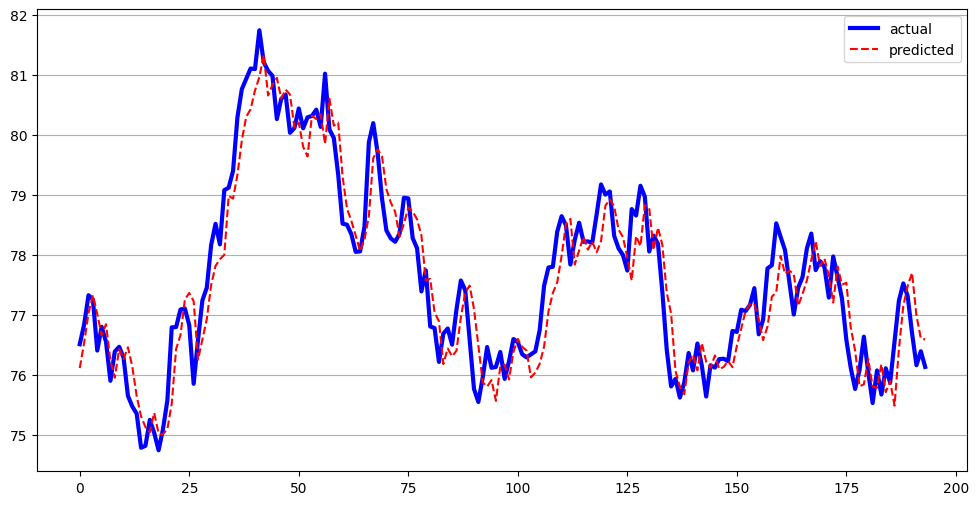

In [41]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.values, label='actual', color='blue', linewidth=3)
plt.plot(y_pred, label='predicted', color='red', linestyle='--')
plt.legend()
plt.grid(axis='y')

## Step 10 – Residual Analysis
### Residuals (difference between actual and predicted values) are plotted over time to evaluate model fit. 
### Patterns in the residuals may indicate model deficiencies, heteroscedasticity, or missing temporal features.

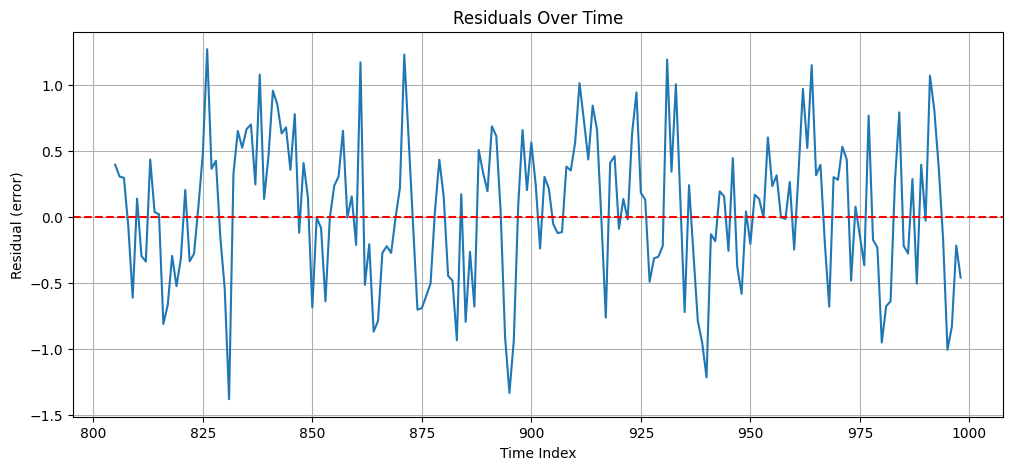

In [42]:
residuals = y_test - y_pred

plt.figure(figsize=(12, 5))

plt.plot(residuals)
plt.axhline(0, color="red", linestyle="--")

plt.title("Residuals Over Time")
plt.xlabel("Time Index")
plt.ylabel("Residual (error)")
plt.grid(True)

## Step 11 – Feature Importance Visualization
### We plot the top 15 features with the largest absolute coefficients to interpret which variables most influence the model’s predictions. 
### Features with higher absolute coefficients have a stronger impact on predicted energy consumption.

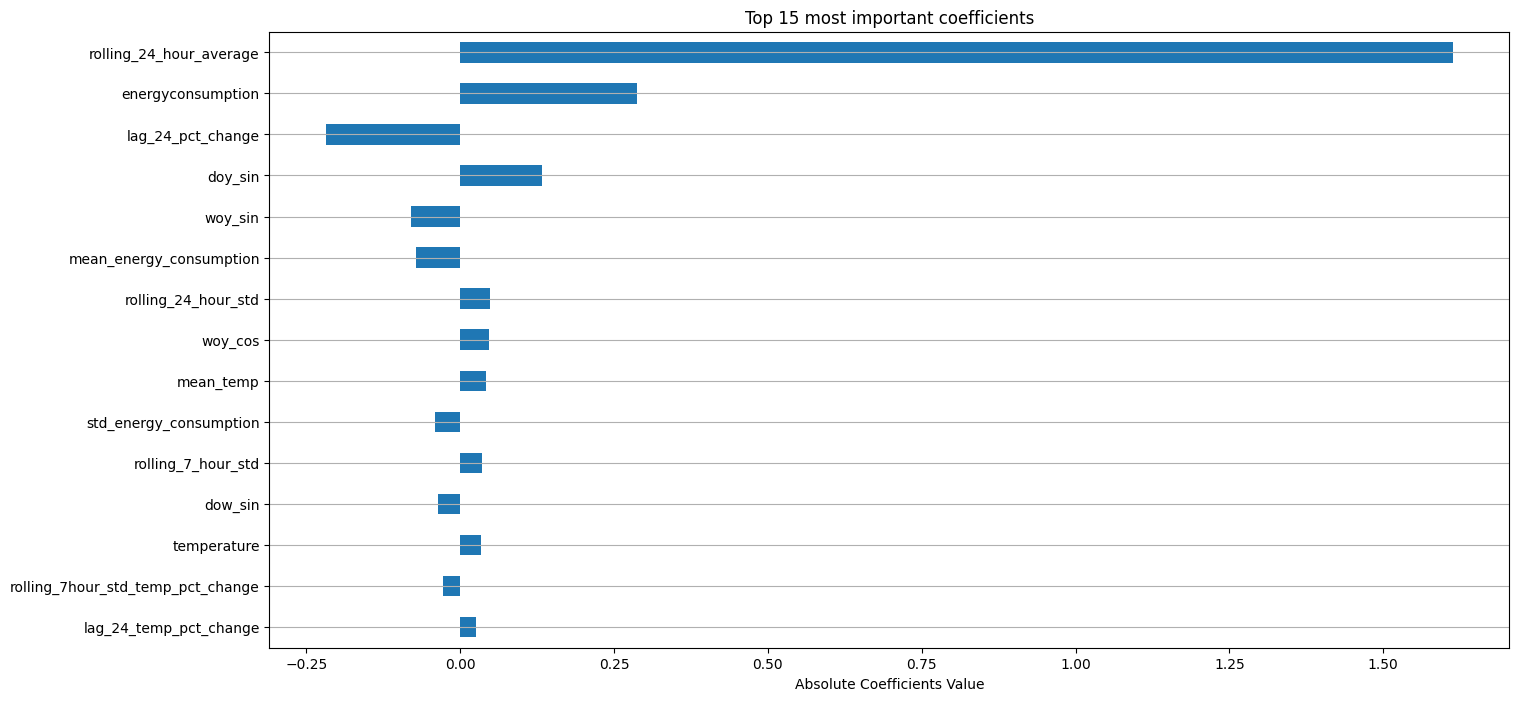

In [43]:
plt.figure(figsize=(16, 8))

coefficients.head(15).plot(kind="barh")

plt.title("Top 15 most important coefficients")
plt.xlabel("Absolute Coefficients Value")
plt.gca().invert_yaxis()
plt.grid(axis='y')

### In this project, we developed a time-series aware linear regression model to predict the 24-hour average energy consumption using historical energy usage data and environmental features.

## Key takeaways:

- Feature engineering is critical: Cyclical encodings, rolling statistics, and lagged features significantly improved model performance.

- Time-aware validation: Using TimeSeriesSplit ensured the model respects temporal dependencies, preventing data leakage.

- Model performance: The Ridge regression model achieved an average R² of 0.88 and stable coefficient estimates across folds, indicating strong predictive capability.

- Insights from features: Rolling averages and lagged percent changes were the most influential predictors, confirming that recent trends are highly predictive of short-term energy consumption.

- Overall, this project demonstrates the importance of thoughtful feature engineering, proper handling of time-series data, and model interpretability in applied energy consumption forecasting. 
- The pipeline and methodology can be extended to other time-dependent forecasting problems or used as a foundation for more complex models such as tree-based or deep learning approaches.